In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import gc, sys, os

In [2]:
UNIT_TIME = 91 # 一個購物週期3個月
UNIT_CNT = 4
UNIT_RECENT_COUNT_THREDSHOLD = 10

## Loading...

In [3]:
df_member = pd.read_csv('../Member.csv')
df_member.info()

D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859146 entries, 0 to 859145
Data columns (total 9 columns):
MemberId                   859146 non-null int64
Birthday                   237275 non-null object
GenderTypeDef              237276 non-null object
RegisterSourceTypeDef      829143 non-null object
RegisterDateTime           859146 non-null object
MinOrderDate               562300 non-null object
OpenCardPresent            859146 non-null int64
LastBirthdayPresentYear    859146 non-null int64
IsInBlackList              1004 non-null object
dtypes: int64(3), object(6)
memory usage: 59.0+ MB


In [4]:
df_ecoupon = pd.read_csv('../ECoupon.csv')
df_ecoupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
ECouponId                    261 non-null int64
ECouponTypeDef               261 non-null object
ECouponStartDateTime         261 non-null object
ECouponEndDateTime           261 non-null object
ECouponUsingStartDateTime    261 non-null object
ECouponUsingEndDateTime      261 non-null object
ECouponDiscountPrice         261 non-null float64
ECouponMaxDiscountLimit      261 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 16.4+ KB


In [5]:
df_promotion = pd.read_csv('../PromotionOrders.csv')
df_promotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011064 entries, 0 to 4011063
Data columns (total 13 columns):
SalesOrderSlaveId                               int64
PromotionId                                     int64
SalesOrderSlavePromotionDiscount                float64
SalesOrderSlavePromotionDiscountAllocated       float64
SalesOrderSlavePromotionDiscountAllocatedQty    int64
SalesOrderSlavePromotionDiscountRate            float64
DiscountType                                    object
PromotionCondition_DiscountPrice                float64
PromotionCondition_DiscountRate                 float64
PromotionCondition_TotalPrice                   float64
PromotionCondition_TotalQty                     int64
PromotionStartDateTime                          object
PromotionEndDateTime                            object
dtypes: float64(6), int64(4), object(3)
memory usage: 397.8+ MB


In [6]:
df_main = pd.read_csv('../Orders.csv')
df_main.info()

D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
DateId                         int64
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId              

## 抓出兩季的資料

In [7]:
df_main['Date'] = pd.to_datetime(df_main['DateId'].astype(str), format='%Y%m%d')

In [8]:
t_begin = df_main['Date'].min()
t_range = pd.Timedelta(120, unit='d')
print(t_begin)

2015-05-06 00:00:00


In [9]:
df_main.drop(labels='DateId', inplace=True, axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId                        object
DeliverTypeDef      

In [10]:
df_mains = {}
SEASON_CNT = 2
for i in range(SEASON_CNT):
    df_mains[i] = \
        df_main[df_main['Date'] < t_begin + t_range * (i + 1)]\
        [df_main['Date'] >= t_begin + t_range * (i)]


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


## Merge Data

In [11]:
for k in df_mains:
    df_mains[k] = df_mains[k].merge(df_ecoupon, on='ECouponId', how='left')
    df_mains[k] = df_mains[k].merge(df_promotion, on='SalesOrderSlaveId', how='left')
    gc.collect()

# 顧客分群 
## 由一季內的單次平均購買 vs 購買次數 進行客群劃分 
   - 分成五群 
       - 流失的客戶 0 vs 0
       

**統計單次消費總額**

In [12]:
main_by_baskets = {}
for k in df_mains:
    main_by_baskets[k] = df_mains[k]\
        .groupby(by=['OrderGroupCode','MemberId'], as_index=False)\
            ['SalesOrderSlaveTotalPayment']\
        .sum()
    print(main_by_baskets[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41425 entries, 0 to 41424
Data columns (total 3 columns):
OrderGroupCode                 41425 non-null object
MemberId                       41425 non-null int64
SalesOrderSlaveTotalPayment    41425 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 118771 entries, 0 to 118770
Data columns (total 3 columns):
OrderGroupCode                 118771 non-null object
MemberId                       118771 non-null int64
SalesOrderSlaveTotalPayment    118771 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ MB
None


### 計算每位會員平均單次消費額
- 用於計算客戶的季度總消費額

In [13]:
member_avgs = {}
def rename_col_to(name, old, new):
    if name == old:
        return new
    else:
        return name

for k in main_by_baskets:
    member_avgs[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('mean')
    member_avgs[k].rename(columns = lambda r: rename_col_to(r, 'SalesOrderSlaveTotalPayment', 'RecentAveragePurchase'), inplace=True)
    print(member_avgs[k].head())

   MemberId  RecentAveragePurchase
0      1329             359.500000
1      1372             125.000000
2      1373             448.000000
3      1423             373.000000
4      1469             543.428571
   MemberId  RecentAveragePurchase
0      1329                  199.0
1      1334                  415.0
2      1391                  593.0
3      1448                  977.0
4      1469                  688.0


**統計客戶的季度總消費額**

In [14]:
member_purchase_cnts = {}
for k in main_by_baskets:
    member_purchase_cnts[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('count')
    print(member_purchase_cnts[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31790 entries, 0 to 31789
Data columns (total 3 columns):
MemberId                       31790 non-null int64
OrderGroupCode                 31790 non-null int64
SalesOrderSlaveTotalPayment    31790 non-null int64
dtypes: int64(3)
memory usage: 993.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80380 entries, 0 to 80379
Data columns (total 3 columns):
MemberId                       80380 non-null int64
OrderGroupCode                 80380 non-null int64
SalesOrderSlaveTotalPayment    80380 non-null int64
dtypes: int64(3)
memory usage: 2.5 MB
None


In [15]:
member_purchase_medians = {}
member_purchase_averages = {}
for k in member_purchase_cnts:
    member_avgs[k]['RecentCount'] = member_purchase_cnts[k]['OrderGroupCode']
    member_avgs[k]['RecentTotal'] = member_avgs[k]['RecentCount'] * member_avgs[k]['RecentAveragePurchase']
    member_purchase_medians[k] = member_avgs[k]['RecentAveragePurchase'].median()
    member_purchase_averages[k] = member_avgs[k]['RecentAveragePurchase'].mean()
    print(member_avgs[k].head())
    print(member_purchase_medians[k])

   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1329             359.500000            2        719.0
1      1372             125.000000            2        250.0
2      1373             448.000000            1        448.0
3      1423             373.000000            1        373.0
4      1469             543.428571            7       3804.0
647.0
   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1329                  199.0            1        199.0
1      1334                  415.0            2        830.0
2      1391                  593.0            1        593.0
3      1448                  977.0            3       2931.0
4      1469                  688.0            5       3440.0
700.6666666666666


**印出各購買次數的會員平均單次購買金額的落點**

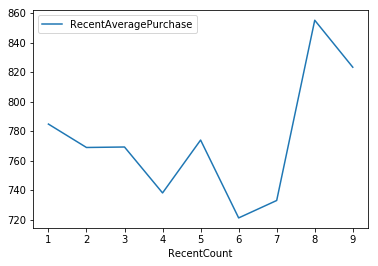

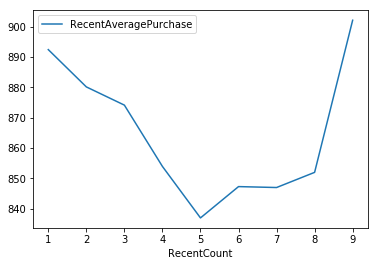

In [16]:
for k in member_avgs:
    tmp0 = member_avgs[k]\
        .groupby(by=['RecentCount'], as_index=False)\
            ['RecentAveragePurchase']\
        .mean()
    tmp0[tmp0['RecentCount'] < UNIT_RECENT_COUNT_THREDSHOLD]\
        .plot.line(x='RecentCount', y='RecentAveragePurchase')
    plt.show()
    gc.collect()
    

## 把各顧客分群並標上標記

In [17]:
RecentCount_threshold = 2

In [18]:
df_members = {}
for k in member_avgs:
    df_members[k] = df_member.merge(member_avgs[k], how='left')
    #print(df_members[k].info())
    #print(df_members[k].head())

In [19]:
df_members[0][~np.isnan(df_members[0]['RecentAveragePurchase'])]

,MemberId,Birthday,GenderTypeDef,RegisterSourceTypeDef,RegisterDateTime,MinOrderDate,OpenCardPresent,LastBirthdayPresentYear,IsInBlackList,RecentAveragePurchase,RecentCount,RecentTotal
8865,1383683,NaN,NaN,Web,2015-08-28 10:44:24.643,2015-08-28,0,0,NaN,399.000000,1.0,399.0
8894,1630818,1980-07-01,Female,Web,2015-08-21 22:20:45.473,2015-08-21,1838,2017,NaN,874.000000,1.0,874.0
8966,1302389,1986-09-20,Female,Web,2015-07-30 22:40:51.403,2015-08-01,318,2017,NaN,1120.000000,1.0,1120.0
8970,1154303,1979-09-11,Female,Web,2015-08-13 22:51:22.167,2015-08-13,318,2017,NaN,647.000000,1.0,647.0
9189,527959,NaN,NaN,NaN,2015-07-14 16:38:07.957,2015-07-11,0,0,NaN,299.000000,2.0,598.0
9190,590713,NaN,NaN,NaN,2015-07-28 14:19:27.403,2015-07-15,0,0,NaN,420.000000,1.0,420.0
9194,1288496,NaN,NaN,NaN,2015-07-28 14:19:01.270,2015-07-23,0,0,NaN,799.000000,1.0,799.0
9195,1452829,NaN,NaN,NaN,2015-07-28 14:21:42.170,2015-07-17,0,0,NaN,573.500000,2.0,1147.0
9265,1382140,NaN,NaN,NaN,2015-07-14 16:38:27.753,2015-07-01,0,0,NaN,1454.000000,1.0,1454.0
9298,403262,1995-11-15,Female,Web,2015-08-29 15:40:47.670,2015-08-29,7693,0,NaN,497.000000,1.0,497.0


In [20]:
from multiprocessing import cpu_count, Pool
def parallelize(df, task, cores = cpu_count()):
    data_split = np.array_split(df, cores)
    pool = Pool(cores)
    data = pd.concat(pool.map(task, data_split))
    pool.close()
    pool.join()
    return data
def parallelize_by_df(dfs, core, func, *args):
    pool = Pool(cores)
    arg = []
    for i in range(dfs.__len__()):
        arg.append(list())
        arg[i].append(dfs, *args)
    pool.map(func, arg)
    pool.start()
    pool.join()
    return data

In [21]:
def set_member_group(row, axis_th_x = RecentCount_threshold, axis_th_y = 0, axis_key_x = 'RecentCount', axis_key_y = 'RecentAveragePurchase'):
    value = 1
    if not np.isnan(row[axis_key_x]) and row[axis_key_x] < axis_th_x:
        if row[axis_key_y] < axis_th_y:
            value = 3
        else:
            value = 2
    elif not np.isnan(row[axis_key_x]):
        if row[axis_key_y] < axis_th_y:
            value = 4
        else:
            value = 1
    
    return value

for k in df_members:
    df_members[k]['MemberGroup'] = df_members[k]\
        .apply(lambda r: set_member_group(r, RecentCount_threshold, member_purchase_medians[k]), axis = 1)

In [22]:
statistics = {}

In [23]:
for k in df_members:
    statistics[k] = pd.DataFrame()
    statistics[k]['MemberCount'] = df_members[k]\
        .groupby(by='MemberGroup')['MemberId']\
        .agg(['count'])['count']
    print(statistics[k])

             MemberCount
MemberGroup             
1                 830727
2                  12679
3                  12846
4                   2894
             MemberCount
MemberGroup             
1                 791082
2                  28211
3                  30009
4                   9844


In [24]:
for k in df_members:
    statistics[k]['TotalSales'] = df_members[k].groupby(by='MemberGroup')['RecentTotal'].agg(['sum'])['sum']
    print(statistics[k])

             MemberCount  TotalSales
MemberGroup                         
1                 830727   8855442.0
2                  12679  14724415.0
3                  12846   5323394.0
4                   2894   3232439.0
             MemberCount  TotalSales
MemberGroup                         
1                 791082  38197307.0
2                  28211  36966141.0
3                  30009  15079925.0
4                   9844  13952686.0


In [25]:
for k in df_members:
    statistics[k].index = ['潛水客', '高消熟客','低消熟客','低消新客','高消新客']
    print(statistics[k])

ValueError: Length mismatch: Expected axis has 4 elements, new values have 5 elements

## 資料整合

- 製作subindex: 對每筆資料加一個序號 

In [ ]:
MAX_CUMCOUNT_OF_PURCHASE = 5 #每位會員最多留存的資料筆數上限

In [ ]:
for k in df_mains:
    df_mains[k]['CumCountOfPurchase'] = df_mains[k].groupby('MemberId').cumcount()
    df_mains[k] = df_mains[k][df_mains[k]['CumCountOfPurchase'] < MAX_CUMCOUNT_OF_PURCHASE]
df_mains[0]

** 清理df_main不必要的欄位 **

In [ ]:
df_mains[0].info()

In [ ]:
DISCARD_LABEL = [
    'District',
    'ZipCode',
    'OrderGroupCode',
    'StoreName',
    'StoreId',
    'SalePageId', # 新版資料集變成數字 無法用one-hot展開
    'SalesOrderReceiverId',
    'SalesOrderSlaveId',
    'SalesOrderSlaveDateTime',
    'ReturnGoodsDateId',
    'CauseDef',
    'ECouponId',
    'ECouponStartDateTime',
    'ECouponEndDateTime',
    'ECouponUsingStartDateTime',
    'ECouponUsingEndDateTime',
    'PromotionId',
    'PromotionStartDateTime',
    'PromotionEndDateTime'
]

In [ ]:
for k in df_mains:
    df_mains[k].drop(labels=DISCARD_LABEL, inplace=True, axis=1, errors='ignore')

df_mains[0].info()

** 把字串轉成數字 **

In [ ]:
for k in df_mains:
    df_mains[k] = pd.get_dummies(df_mains[0])
    gc.collect()


** 把表格平攤 **

In [ ]:
df_main_pivot_tables = {}
for k in df_mains:
    df_main_pivot_tables[k] = pd.pivot_table(df_mains[k], index='MemberId', columns='CumCountOfPurchase',fill_value=0.0)
    df_main_pivot_tables[k].columns = [it[0] + str(it[1]) for it in df_main_pivot_tables[k].columns.tolist() if True]
    df_main_pivot_tables[k]['MemberId'] = df_main_pivot_tables[k].index
    df_main_pivot_tables[k].index = range(df_main_pivot_tables[k].shape[0])
    gc.collect()
df_main_pivot_tables[0]

** 清理 df_member **

In [ ]:
DISCARD_LABEL_MEMBER = [
    'RegisterDateTime',
    'MinOrderDate',
    'LastBirthdayPresentYear',
    'IsInBlackList',
    'MinOrderDate'
]

In [ ]:
df_members[0].head()

In [ ]:
for k in df_members:
    df_members[k].drop(labels=DISCARD_LABEL_MEMBER, inplace=True, axis=1, errors='ignore')

## Bottleneck

In [ ]:
# 日期轉型
def to_datetime_safe(row, label, na = np.NaN):
    try:
        return pd.to_datetime(row[label], format='%Y-%m-%d')
    except Exception as e:
        sys.stderr.write('Invalid datetime string: %r\n'%(row[label]))
        return na

for k in df_members:
    df_members[k]['Birthday'] = df_members[k].apply(lambda r: to_datetime_safe(r, 'Birthday'), axis=1)

df_members[0].info()

In [ ]:
for k in df_members:
    df_members[k] = pd.get_dummies(df_members[k])    

** 和df_member合併 **

In [ ]:
#debug
def print_type(df):
    tp = df.dtypes
    for i in range(tp.__len__()):
        print('%s %s'%(df.columns[i], tp[i]))

In [ ]:
for k in df_members:
    df_members[k] = df_members[k].merge(df_main_pivot_tables[k], on='MemberId', how='left')
    gc.collect()
df_members[0].info()


In [ ]:
def replace_col_label(df, old_label, new_label):
    col = list(df.columns)
    for i in range(len(col)):
        if col[i] == old_label:
            col[i] = new_label
            df.columns = col
            return

for i in range(len(df_members)):
    if i == len(df_members) - 1:
        break
    df = df_members[i + 1].loc[:, ['MemberId', 'MemberGroup']]
    replace_col_label(df, 'MemberGroup', 'MemberGroupNext')
    print(df.shape)
    df_members[i] = df_members[i].merge(df, on='MemberId', how='left')
    df_members[i]['MemberGroupNext'].fillna(1, inplace=True)
    gc.collect()

#df_members[0].dtypes

## 訓練

In [ ]:
# 該季取樣比例 (不能全部套用 記憶體會爆炸)
MOTHER_SAMPLE_COUNT = 100000
# test/sample比例
TEST_FRACTION = 0.25
rfcs = {}
rfc_models = {}

test = pd.DataFrame()
for k in df_members:
    if k >= len(df_members) - 1:
        break
    #debug
    # todo convert Timestamp to int64
    #enddebug
    try:
        cache_df = df_members[k].sample(n = MOTHER_SAMPLE_COUNT)
        train, test = train_test_split(
            cache_df, 
            test_size = TEST_FRACTION
        )
        print('season %i raw shape: %r'%(k, cache_df.shape))
        #debug
        train.drop(columns=['Birthday'], inplace=True)
        test.drop(columns=['Birthday'], inplace=True)
        # 篩掉該季沒出現的
        print('train original: %i'%(train.shape[0]))
        train = train[train['MemberGroup'] != 1]
        print('train new: %i'%(train.shape[0]))
        #drop na where MemberGroupNext has nan value
        ##cache_df = cache_df[np.isfinite(df['MemberGroupNext'])]
        # 保留 MemberGroupNext空值 視同潛水客戶w
        train['MemberGroupNext'].fillna(1, inplace=True)
        test['MemberGroupNext'].fillna(1, inplace=True)
        
        # impute NA
        imputer = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
        imputer = imputer.fit(train)
        train_ndarr = imputer.fit_transform(train.drop(
                labels=['MemberId', 'MemberGroupNext'], 
                axis = 1,
                errors='ignore'))
        test_ndarr = imputer.fit_transform(test.drop(
                labels=['MemberId', 'MemberGroupNext'], 
                axis = 1, 
                errors='ignore'))
        
        #train.fillna(0, inplace=True)
        #print(cache_df.dtypes)
        #enddebug
        print('season %i filtered shape: %r'%(k, train.shape))
        
        rfcs[k] = RandomForestClassifier(
            criterion='entropy',
            n_estimators=25, 
            class_weight='balanced'
        )
        rfc_models[k] = rfcs[k].fit(
            train_ndarr, 
            train['MemberGroupNext']
        )
        
        test['predicted'] = rfc_models[k].predict(
            test_ndarr
        )
    
        accuracy = test.loc[:,['predicted', 'MemberGroupNext']]\
            .apply(lambda r: r['predicted'] == r['MemberGroupNext'], axis =1)\
            .sum()/test.shape[0]
            
        print('in group %i:\test naccuracy: %f\n\n'%(k, accuracy))
        #print(test.loc[:, ['predicted', 'MemberGroupNext']])
        
        
    except Exception as e:
        sys.stdout.write('Error occurs at season %i\n'%k)
        raise e
    finally:
        gc.collect()
        

In [ ]:
tt = 0
others = 0
ff = 0
pred_zero = 0
def decision(df_, test_, predict_):
    global tt, others, ff, pred_zero
    if not df_[predict_]:
        pred_zero += 1
    if not df_[test_] and not df_[predict_]:
        ff += 1
        return
    if df_[test_] == df_[predict_]:
        tt += 1
        return
    others += 1

test.apply(lambda r: decision(r, 'MemberGroupNext', 'predicted'), axis = 1)
print('Test Pred')
print('Total: %i'%test.shape[0])
print('0  ==  0: %f%%'%(ff/test.shape[0] * 100))
print('n  ==  n: %f%%'%(tt/test.shape[0] * 100))
print('   !=   : %f%%'%(others/test.shape[0] * 100))
print('\npred == 0: %f%%'%(pred_zero/test.shape[0] * 100))

tt = 0
others = 0
ff = 0
pred_zero = 0

** 此季回頭率**

In [ ]:
group_ = [2,3,4,5]
for k in df_members:
    if k >= len(df_members) - 1:
        break
    print('In season %i:'%k)
    current = df_members[k]
    for j in group_:
        numerator = (current\
        [((current['MemberGroup']==j) & (~np.isnan(current['MemberGroup'])))]\
        [((current['MemberGroupNext']>1) & (~np.isnan(current['MemberGroupNext'])))]\
        .shape[0])
        denominator = (current\
        [((current['MemberGroup']==j) & (~np.isnan(current['MemberGroup'])))].shape[0])
        #print('%f %f'%(numerator, denominator))
        ret_rate = 0
        try:
            ret_rate = numerator/denominator
        except ZeroDivisionError as e:
            ret_rate = 0.0
        print('group %i: return: %i, all: %i, return rate %f%%'%(j, numerator, denominator, ret_rate * 100))
    numerator = (\
        current[((current['MemberGroup']) &\
            (~np.isnan(current['MemberGroup'])))]\
        [((current['MemberGroupNext']) &\
            (~np.isnan(current['MemberGroupNext'])))]\
        .shape[0])
    denominator = (current[((current['MemberGroup']) &\
                            (~np.isnan(current['MemberGroup'])))].shape[0])
    ret_rate = numerator/denominator
    print('group all: return: %i, all: %i, return rate %f%%'%(numerator, denominator, ret_rate * 100))